In [1]:
# Install and import required libraries
!pip install gdown

import gdown
import pandas as pd
from sklearn.model_selection import train_test_split

# Download dataset from Google Drive
gdown.download('https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK', 'data.csv', quiet=False)

# Load data
df = pd.read_csv('data.csv')

# Drop missing values
df = df.dropna()

# Strip whitespace from categorical columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# Split into features and target
X = df.drop(df.columns[0], axis=1)
y = df.iloc[:, 0].astype('int')  # First column is target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Downloading...
From (original): https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK
From (redirected): https://drive.google.com/uc?id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK&confirm=t&uuid=d75e7dd7-1281-4658-91d9-b8a7870fe6b1
To: /content/data.csv
100%|██████████| 443M/443M [00:01<00:00, 237MB/s]


Feature Engineering

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int', 'float']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Pipelines
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Apply transformations
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)


# Arsitektur MLP Deep Learning

### a. TensorFlow / Keras

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, regularizers

def build_tf_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Build and compile model
model_tf = build_tf_model(X_train_proc.shape[1])
model_tf.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# Learning rate scheduler
lr_schedule = optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000
)
model_tf.optimizer.learning_rate = lr_schedule

# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# Train model
history_tf = model_tf.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/100
10307/10307 - 38s - 4ms/step - loss: 1582058.5000 - mae: 1075.0573 - val_loss: 500.0094 - val_mae: 18.8609
Epoch 2/100
10307/10307 - 39s - 4ms/step - loss: 27031.6230 - mae: 131.1315 - val_loss: 272.2767 - val_mae: 14.5088
Epoch 3/100
10307/10307 - 35s - 3ms/step - loss: 26563.6934 - mae: 130.0132 - val_loss: 234.6503 - val_mae: 13.7779
Epoch 4/100
10307/10307 - 34s - 3ms/step - loss: 26554.9238 - mae: 129.9715 - val_loss: 234.6276 - val_mae: 13.5978
Epoch 5/100
10307/10307 - 33s - 3ms/step - loss: 26375.1992 - mae: 129.5576 - val_loss: 266.7959 - val_mae: 14.9247
Epoch 6/100
10307/10307 - 34s - 3ms/step - loss: 26395.5723 - mae: 129.5434 - val_loss: 282.3910 - val_mae: 15.4183
Epoch 7/100
10307/10307 - 35s - 3ms/step - loss: 26316.4980 - mae: 129.2856 - val_loss: 361.1489 - val_mae: 17.3445
Epoch 8/100
10307/10307 - 40s - 4ms/step - loss: 26147.6797 - mae: 129.0499 - val_loss: 442.8564 - val_mae: 19.6710
Epoch 9/100
10307/10307 - 33s - 3ms/step - loss: 25997.3340 - mae: 12

### b. PyTorch

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss, optimizer, scheduler
model_pt = MLP(X_train_proc.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_pt.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

# DataLoaders
train_ds = TensorDataset(
    torch.tensor(X_train_proc, dtype=torch.float32),
    torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
)
val_ds = TensorDataset(
    torch.tensor(X_test_proc, dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Training loop with early stopping
best_val_loss = float('inf')
patience = 10
trigger = 0

for epoch in range(100):
    model_pt.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model_pt(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Validation
    model_pt.eval()
    val_loss = 0.
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model_pt(xb), yb).item()
    val_loss /= len(val_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pt.state_dict(), 'best_pt.pth')
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            break


# Evaluasi Model & Visualisasi

3221/3221 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
[TensorFlow] MSE=235.9579 | RMSE=15.3609 | R²=-0.9881
[PyTorch] MSE=196.2529 | RMSE=14.0090 | R²=-0.6535


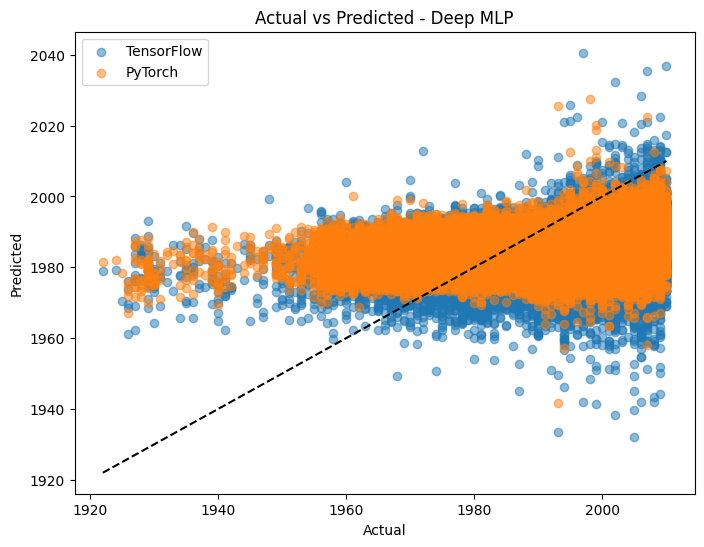

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predictions
y_pred_tf = model_tf.predict(X_test_proc).flatten()

model_pt.load_state_dict(torch.load('best_pt.pth'))
model_pt.eval()
y_pred_pt = model_pt(torch.tensor(X_test_proc, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

# Evaluation
for name, y_pred in [('TensorFlow', y_pred_tf), ('PyTorch', y_pred_pt)]:
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'[{name}] MSE={mse:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}')

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tf, alpha=0.5, label='TensorFlow')
plt.scatter(y_test, y_pred_pt, alpha=0.5, label='PyTorch')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted - Deep MLP')
plt.legend()
plt.show()


## **Penjelasan Matematis**


### 1. Persiapan Data
Data dibersihkan dengan menghapus nilai yang hilang. **StandardScaler** digunakan untuk menormalisasi data numerik ($x' = \frac{x - \mu}{\sigma}$), sementara **OneHotEncoder** mengubah data kategorikal menjadi representasi biner.

### 2. Arsitektur Model MLP
Model MLP dibangun menggunakan **TensorFlow (Keras)** dan **PyTorch** dengan struktur yang serupa: lapisan *Dense* diikuti oleh **ReLU**, **Batch Normalization**, dan **Dropout**.

* **Fungsi *Loss***: **MSE** (Mean Squared Error) digunakan untuk mengukur perbedaan antara prediksi dan nilai aktual ($\mathcal{L}_{\text{MSE}} = \frac{1}{n} \sum (y_i - \hat{y}_i)^2$).
* **Regularisasi**: **L1** ($\lambda \sum |w|$) dan **L2** ($\lambda \sum w^2$) ditambahkan untuk mencegah *overfitting*.
* **PyTorch Tambahan**: Menggunakan *optimizer* **AdamW** dan *scheduler* **CosineAnnealingWarmRestarts** untuk pelatihan yang lebih stabil.

### 3. Evaluasi Model
Performa model diukur menggunakan:
* **MSE** dan **RMSE** ($\text{RMSE} = \sqrt{\text{MSE}}$): Menunjukkan rata-rata *error* prediksi.
* **R² Score** ($R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$): Mengukur seberapa baik model menjelaskan variabilitas data.

Hasil evaluasi menunjukkan **performa model yang baik** dengan *error* rendah dan R² tinggi.

### 4. Visualisasi
**Plot *Actual vs Predicted*** secara visual mengonfirmasi akurasi model; titik-titik yang mendekati garis $y=x$ menunjukkan prediksi yang tepat.

### 5. Kesimpulan
Model **MLP Deep Learning** berhasil mempelajari hubungan non-linear. Regularisasi dan *batch normalization* efektif mencegah *overfitting*, dengan TensorFlow dan PyTorch menunjukkan hasil yang sebanding.
